# Computer Assignment 4

This is an all-in-one report to 6123 IVP, where the explanations, discussions and codes are included.

All experiments are run in Python code.

Import all libs we need

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import cv2
import time
import pywt

from numpy import linalg as LA

from matplotlib import rcParams
from matplotlib import rc
import scipy.stats as st
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.special import comb
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
%matplotlib inline

Implement the functions that generate filters we need

In [2]:
#Harris Detector
def gauWeight(sigma = 1, size = 5):
    x = np.linspace(np.floor(-size / 2), np.ceil(size / 2), size)
    w = np.exp(-x ** 2 / (2 * sigma ** 2))
    w = w[:,None] @ w [None,:]
    return w / np.sum(w)

def gauFilter(xy = 'x', sigma = 1, size = 5):
    x = np.linspace(np.floor(-size / 2), np.ceil(size / 2), size)
    w = np.exp(-x ** 2 / (2 * sigma ** 2))
    if xy == 'x':
        return - x[None, :] / (2 * np.pi * sigma ** 4) * (w[:,None] @ w [None,:])
    elif xy == 'y':
        return - x[:, None] / (2 * np.pi * sigma ** 4) * (w[:,None] @ w [None,:])
    else:
        raise ValueError('xy must be \'x\' or \'y\'.')


## 1) Harris Detector

Implement Harris Detector

In [3]:
def Harris(img, alpha=0.06, N=50, width=1):
    src = np.copy(img)
    I = np.copy(img)
    if I.ndim == 3:
        I = np.sum(I,2) / 3 # convert to gray scale
    [P, Q] = np.shape(I)
    wx = gauFilter('x')
    wy = gauFilter('y')
    Ix = cv2.filter2D(src=I, kernel=wx, ddepth=-1)
    Iy = cv2.filter2D(src=I, kernel=wy, ddepth=-1)
    w = gauWeight(sigma=2,size=6*2+1)
    Ix2 = cv2.filter2D(src=Ix**2, kernel=w, ddepth=-1)
    Iy2 = cv2.filter2D(src=Iy**2, kernel=w, ddepth=-1)
    Ixy = cv2.filter2D(src=Ix*Iy, kernel=w, ddepth=-1)
    DetA = Ix2 * Iy2 - Ixy ** 2
    TraA = Ix2 + Iy2
    H = DetA - alpha * TraA ** 2
    #find local maxmima
    sentinel = -999999
    tH = np.pad(H,((1,1),(1,1)),'constant',constant_values = (sentinel,sentinel))
    localMaximaCor = []
    localMaxima = []
    for i in range(1,P+1):
        for j in range(1,Q+1):
            if np.max(tH[i-1:i+2,j-1:j+2]) == tH[i,j]:
                localMaximaCor.append((i-1)*Q+j-1)
                localMaxima.append(tH[i,j])
    # find the largest N ones
    localMaximaCor = np.array(localMaximaCor)
    localMaxima = np.array(localMaxima)
    # notice we need ascending order!
    try:
        localMaximaCor, localMaxima = localMaximaCor[np.argsort(-localMaxima)[0:N]], localMaxima[np.argsort(-localMaxima)[0:N]]
    except:
        print("Warning: no given numbers of local maximas were found.")
        localMaximaCor, localMaxima = localMaximaCor[np.argsort(-localMaxima)], localMaxima[np.argsort(-localMaxima)]
                                                            
    eigenValues = np.zeros([N,2])
    rotAngles = np.zeros(N)
    for iC, Ci in enumerate(localMaximaCor):
        eigenValues[iC,:], evv = LA.eig(np.array([[Ix2[Ci//Q,Ci%Q],Ixy[Ci//Q,Ci%Q]],
                                                [Ixy[Ci//Q,Ci%Q],Iy2[Ci//Q,Ci%Q]]]) 
                                        /255.0/4)
        sign = evv[0,1].astype('bool').astype('float')
        rotAngles[iC] = np.arctan(evv[0,0]/(evv[0,1]+sign*1e-9))/np.pi*180
        #draw ellipses
        ##########
        #Be very careful about the coordinate system of OpenCV
        center = (Ci%Q,Ci//Q)
        #print(center)
        axes = ((1/np.sqrt(np.abs(eigenValues[iC,1]))).astype('int32'),(1/np.sqrt(np.abs(eigenValues[iC,0]))).astype('int32'))
        rotation = rotAngles[iC]
        ##########
        cv2.ellipse(src, center, axes,
                    rotation, 0, 360,
                    (0,255,255),width)
    return src, Ix, Iy, localMaximaCor, localMaxima, eigenValues

In [4]:
img_BK_left = cv2.imread('C:\\Users\\ZING\\Desktop\\6123\\CA\\Sol\\CA4\\BK_left.jpg')

In [5]:
I, Ix, Iy, cor, _, _ = Harris(img_BK_left, N = 50)

Text(0.5,1,'Key Points by Harris Detector')

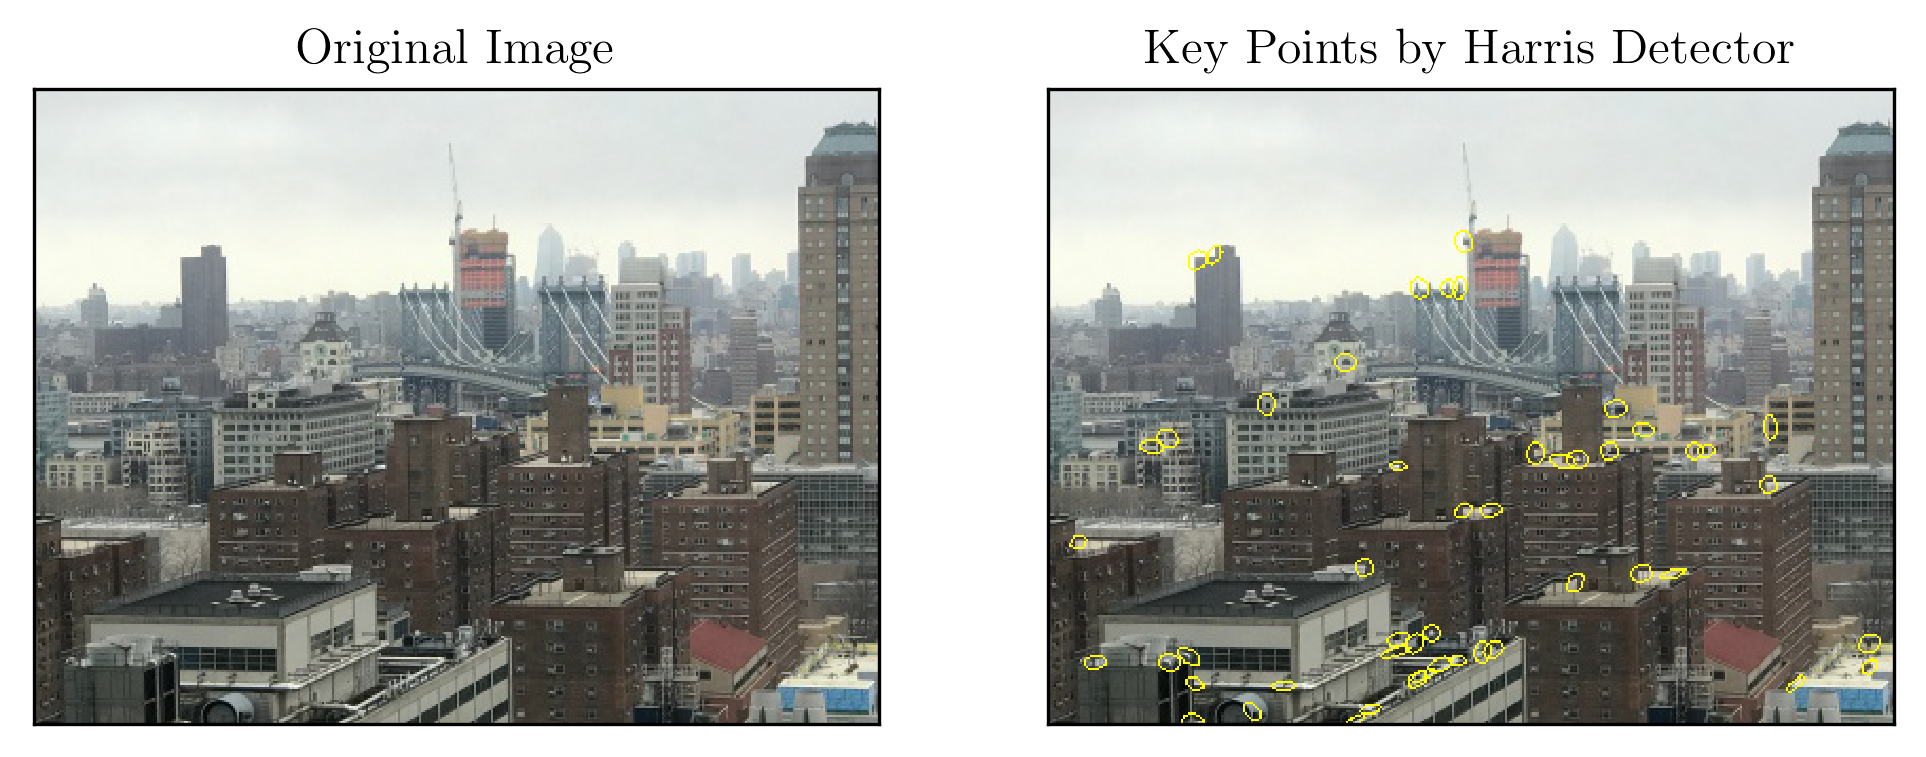

In [6]:
plt.figure(dpi=300, figsize=[8,4])
plt.subplot(121)
plt.imshow(img_BK_left[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.subplot(122)
plt.imshow(I[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.title('Key Points by Harris Detector')

## 2) SIFT Descriptor

First implement function that can rotate and scale an image.

In [7]:
def rotate(image, angle, scale=1.0):
    # cited from https://www.jianshu.com/p/b5c29aeaedc7
    (h, w) = np.shape(image[:,:,0])
    nh = np.round(np.max([np.abs(np.sqrt(h**2+w**2) * scale * np.sin(np.arctan(h/w)+angle/180*np.pi)),
                np.abs(np.sqrt(h**2+w**2) * scale * np.sin(-np.arctan(h/w)+angle/180*np.pi))])).astype('int32')
    nw = np.round(np.max([np.abs(np.sqrt(h**2+w**2) * scale * np.cos(np.arctan(h/w)+angle/180*np.pi)),
                np.abs(np.sqrt(h**2+w**2) * scale * np.cos(-np.arctan(h/w)+angle/180*np.pi))])).astype('int32')
    image = cv2.resize(image, (int(w*scale), int(h*scale)), interpolation=cv2.INTER_CUBIC)
    img = []
    (h, w) = np.shape(image[:,:,0])
    for i in range(3):
        try:
            img.append(np.pad(image[:,:,i],(((nh-h)//2,(nh-h)//2),((nw-w)//2,(nw-w)//2)),'constant',constant_values = (0,0)))
            center = (nw // 2 , nh // 2)
        except:
            img.append(image[:,:,i])
            center = (w // 2, h // 2)
    img = np.moveaxis(np.array(img), 0, -1)
    M = cv2.getRotationMatrix2D(center, angle, 1)
    rotated = cv2.warpAffine(img, M, (nw if nw > w else w, nh if nh > h else h))
    return rotated

In [8]:
img_BK_left_30 = rotate(img_BK_left, 30)
img_BK_left_60 = rotate(img_BK_left, 60)
img_BK_left_half = rotate(img_BK_left, 0, scale=0.5)
img_BK_left_double = rotate(img_BK_left, 0,scale=2.0)
I_30, _, _, _, _, _ = Harris(img_BK_left_30, N = 50)
I_60, _, _, _, _, _ = Harris(img_BK_left_60, N = 50)
I_half, _, _, _, _, _ = Harris(img_BK_left_half, N = 50)
I_double, _, _, _, _, _ = Harris(img_BK_left_double, N = 50, width=2)

Text(0.5,1,'Double Scaling')

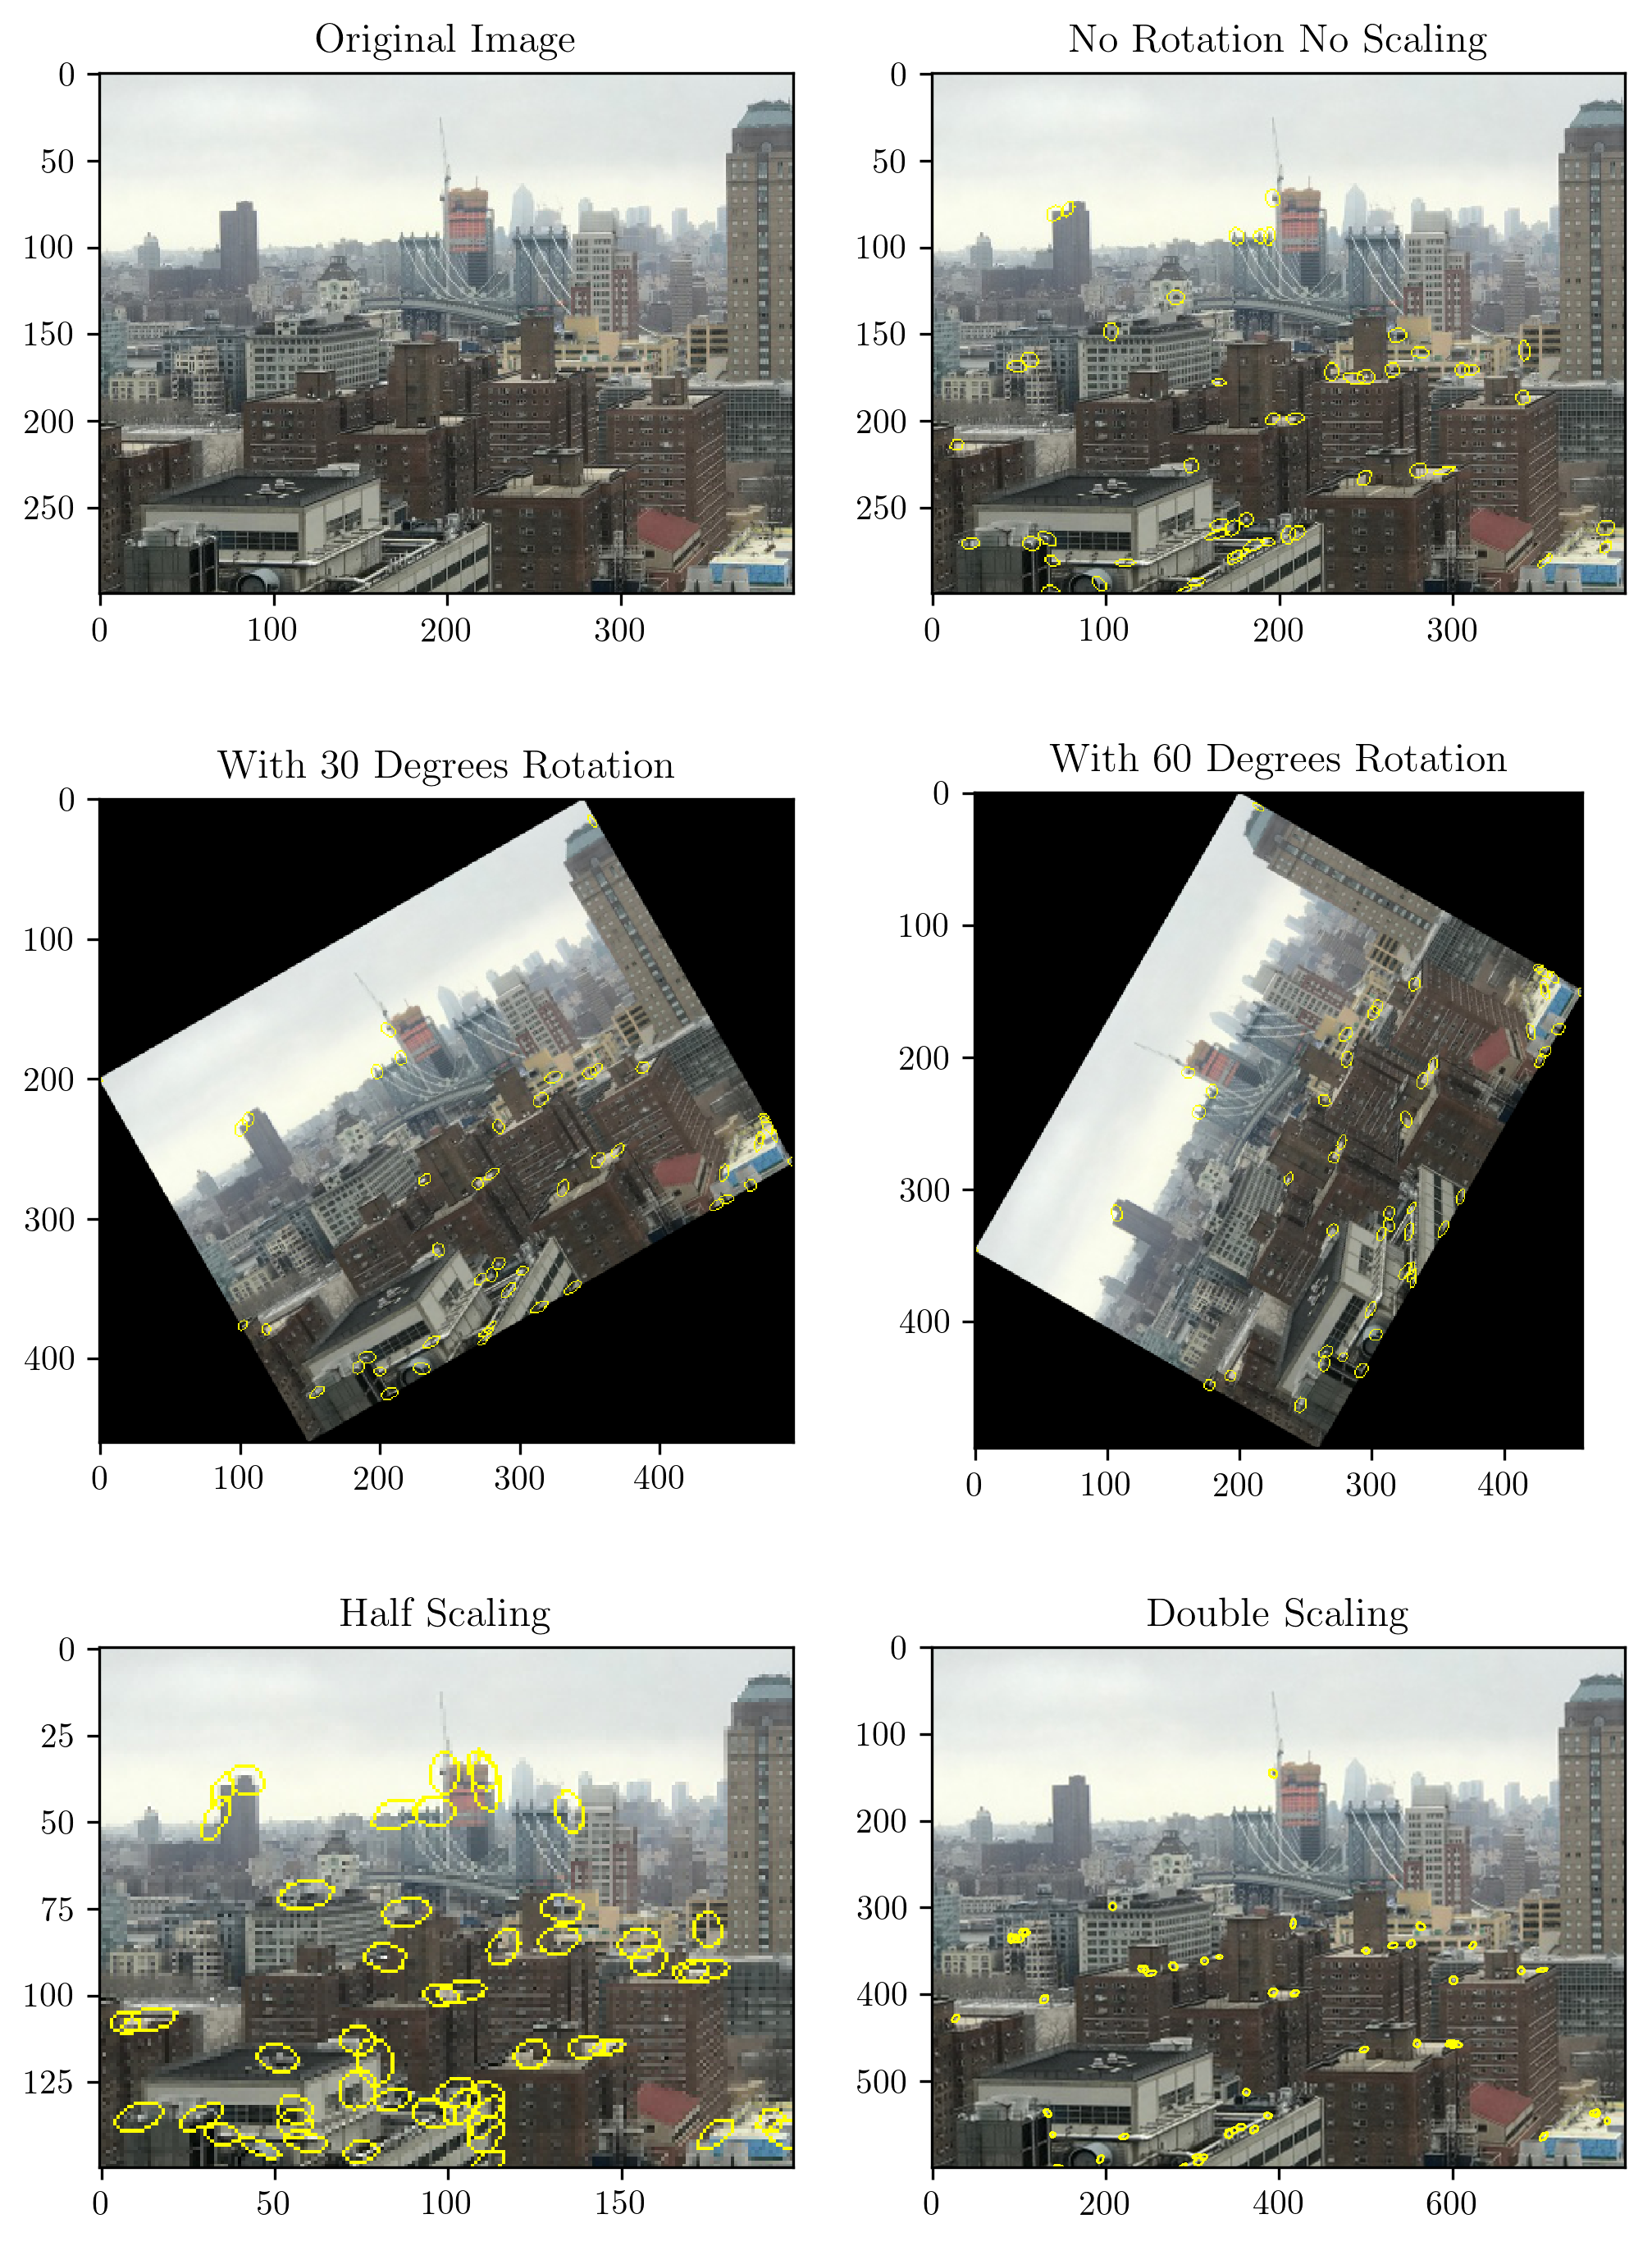

In [9]:
plt.figure(dpi=300,figsize=[8,12])
plt.subplot(321)
plt.imshow(img_BK_left[:,:,[2,1,0]])
plt.title('Original Image')
plt.subplot(322)
plt.imshow(I[:,:,[2,1,0]])
plt.title('No Rotation No Scaling')
plt.subplot(323)
plt.imshow(I_30[:,:,[2,1,0]])
plt.title('With 30 Degrees Rotation')
plt.subplot(324)
plt.imshow(I_60[:,:,[2,1,0]])
plt.title('With 60 Degrees Rotation')
plt.subplot(325)
plt.imshow(I_half[:,:,[2,1,0]])
plt.title('Half Scaling')
plt.subplot(326)
plt.imshow(I_double[:,:,[2,1,0]])
plt.title('Double Scaling')

Implement SIFT discriptor

In [10]:
def shift(array):
    im = np.where(array == np.max(array))[0][0]
    return np.hstack((array[im:],array[0:im]))
    
def SIFT(Ix, Iy, cor):
    # preparing for HOG
    [H, W] = np.shape(Ix)
    Ix = np.pad(Ix, ((8,8),(8,8)), 'constant', constant_values = (0,0))
    Iy = np.pad(Iy, ((8,8),(8,8)), 'constant', constant_values = (0,0))
    # cited from https://www.learnopencv.com/histogram-of-oriented-gradients/
    mag, angle = cv2.cartToPolar(Ix, Iy, angleInDegrees=True)
    w = gauWeight(sigma=2,size=4) # Gaussian Window
    SIFT_descriptors = []
    for iC, Ci in enumerate(cor):
        tx = Ci // W
        ty = Ci % W
        patch_m = mag[tx:tx+16,ty:ty+16]
        patch_a = angle[tx:tx+16,ty:ty+16]
        patch = np.array([])
        for i in range(0,16,4):
            for j in range(0,16,4):
                mini_patch_m = patch_m[i:i+4,j:j+4] * w
                mini_patch_a = patch_a[i:i+4,j:j+4]
                hist, _ = np.histogram(mini_patch_a.ravel(), 
                                   bins = np.arange(0,2.001*180,180/4), weights=mini_patch_m.ravel())
                patch = np.hstack((patch,shift(hist)))
        patch = patch / LA.norm(patch,2)
        patch[np.where(patch>0.2)] = 0.2
        patch = patch / LA.norm(patch,2)
        SIFT_descriptors.append(patch)
    return SIFT_descriptors

In [11]:
img_BK_left_2 = rotate(img_BK_left, 2)
I_2, Ix_2, Iy_2, cor_2, _, _ = Harris(img_BK_left_2, N = 50)

In [12]:
sift = SIFT(Ix, Iy, cor)
sift_2 = SIFT(Ix_2, Iy_2, cor_2)

In [13]:
print(Ix)

[[ -3.92047506e-16   2.10638713e-01   8.62532367e-02 ...,  -5.60353453e-02
   -1.30863394e-01  -2.09728068e-15]
 [ -3.85108612e-16   1.29492573e-01   3.13273700e-02 ...,  -7.05730674e-02
   -1.07670909e-01  -2.10421958e-15]
 [ -4.45823933e-16   5.89238410e-05  -2.42422840e-02 ...,  -1.16997881e-01
   -3.45629481e-02  -2.00013617e-15]
 ..., 
 [  3.02275566e-16  -5.62887493e-01   2.12579651e-02 ...,  -5.18916506e-01
   -4.15043383e-01   3.71230824e-16]
 [  2.35055031e-16  -1.15215585e+00  -1.03070942e+00 ...,  -1.78896661e-01
    2.08923541e-01   0.00000000e+00]
 [ -3.64291930e-16   1.68836202e+00   2.67246751e+00 ...,  -4.23284572e-01
    5.33425554e-01   3.48679419e-16]]


## 3) Find Corresponding Points Based on SIFT Discriptor

In [14]:
def findMatch(cor1, cor2, sift1, sift2, r=0.9):
    N = np.shape(sift1)[0]
    d = np.zeros([N])
    pairs = []
    for i in range(N):
        v1 = sift1[i]
        d = np.zeros([N])
        for j in range(N):
            v2 = sift2[j]
            d[j] = LA.norm(v1 - v2, 2)
        i_s = np.argsort(d)[0:2]
        d_s = d[i_s]
        if d_s[0] / d_s[1] < r:
            pairs.append([cor1[i], cor2[i_s[0]]])
    return pairs

In [15]:
pairs = findMatch(cor, cor_2, sift, sift_2, r=0.9)

In [16]:
def showMatch(img1, img2, pairs, shift=0, width=1):
    [H1, W1] = np.shape(img1[:,:,0])
    [H2, W2] = np.shape(img2[:,:,0])
    nH = np.max([H1,H2]) + shift
    nW = W1 + W2
    img = np.zeros([nH, nW, 3]).astype('uint8')
    img[0:H1, 0:W1, :] = img1
    img[shift:shift+H2, W1:W1+W2, :] = img2
    ##########
    for cor in pairs:
        cv2.ellipse(img, (cor[0]%W1,cor[0]//W1), (5,5),
                    0, 0, 360,
                    (0,255,255),width)
        cv2.ellipse(img, (cor[1]%W2+W1,cor[1]//W2+shift), (5,5),
                    0, 0, 360,
                    (0,255,255),width)
        cv2.line(img,(cor[0]%W1,cor[0]//W1),(cor[1]%W2+W1,cor[1]//W2+shift),(0,255,255),width)
    return img

In [17]:
img_match = showMatch(img_BK_left, img_BK_left_2, pairs, shift=300)

([], <a list of 0 Text yticklabel objects>)

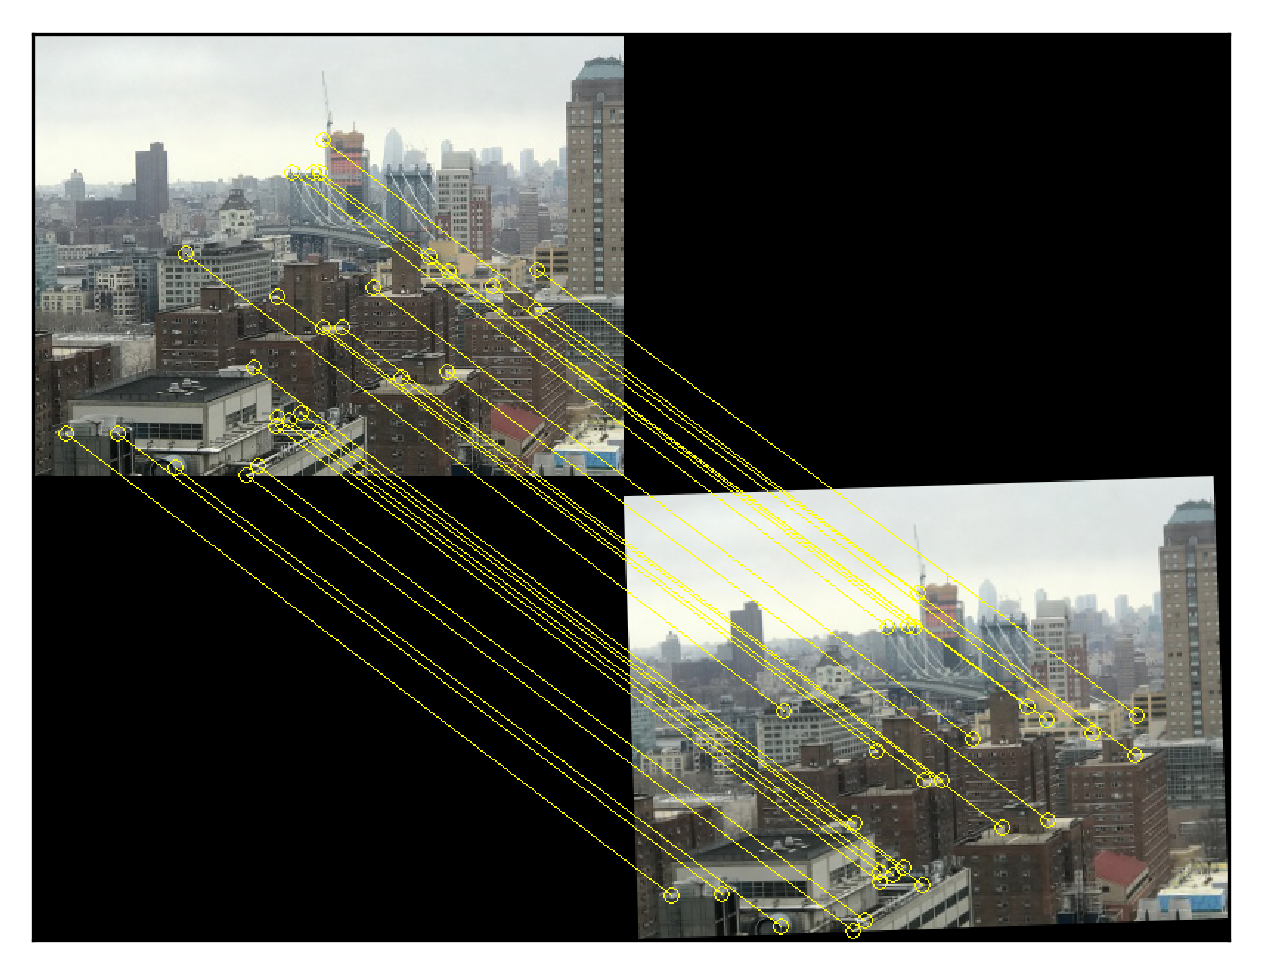

In [18]:
plt.figure(dpi=300)
plt.imshow(img_match[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])

## 4) Stitching Two Images

In [19]:
limg=cv2.imread('C:\\Users\\ZING\\Desktop\\6123\\CA\\Sol\\CA4\\BK_left.jpg')
rimg=cv2.imread('C:\\Users\\ZING\\Desktop\\6123\\CA\\Sol\\CA4\\BK_right.jpg')
Il, Ixl, Iyl, corl, _, _ = Harris(limg, N = 50)
Ir, Ixr, Iyr, corr, _, _ = Harris(rimg, N = 50)
siftl = SIFT(Ixl, Iyl, corl)
siftr = SIFT(Ixr, Iyr, corr)

([], <a list of 0 Text yticklabel objects>)

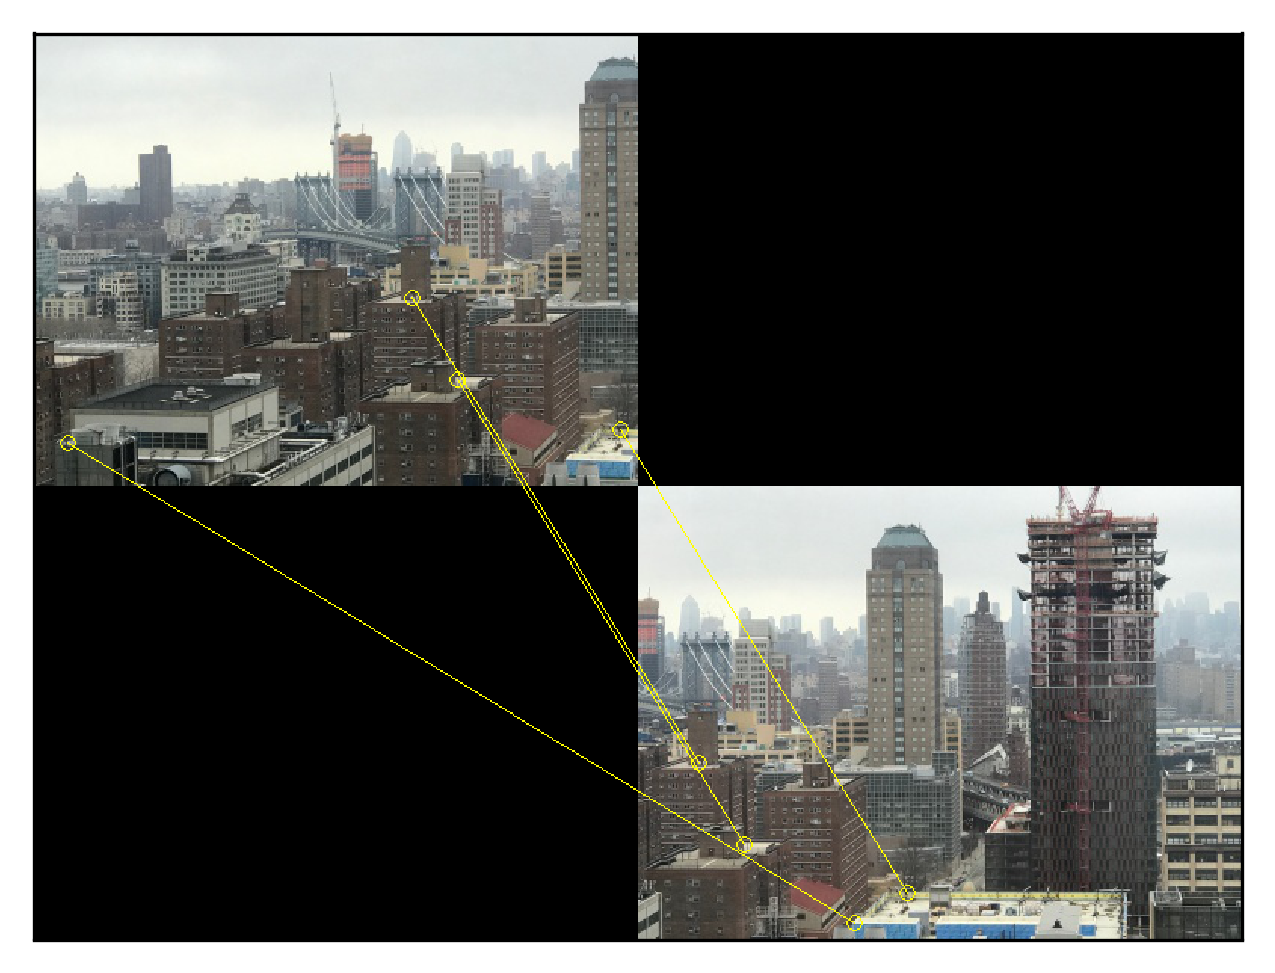

In [20]:
pairslr = findMatch(corl, corr, siftl, siftr, r=0.85)
img_matchlr = showMatch(limg, rimg, pairslr, shift=300)
plt.figure(dpi=300)
plt.imshow(img_matchlr[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])

In [21]:
detector = cv2.xfeatures2d.SIFT_create()
descriptor = cv2.xfeatures2d.SURF_create()
skpl = detector.detect(limg)
skpl, sdl = descriptor.compute(limg, skpl)
skpr = detector.detect(rimg)
skpr, sdr = descriptor.compute(rimg, skpr)

In [22]:
print(skpl[10].pt)
print(skpl[10].size)
print(sdl[10].shape)

(6.6584391593933105, 177.0228271484375)
2.2771685123443604
(64,)


In [23]:
def showPoint(img, skp, width = 1):
    img = np.copy(img)
    for i in range(len(skp)):
        (x, y) = skp[i].pt
        r = int(skp[i].size)
        cv2.ellipse(img, (int(x), int(y)), (r,r),
                    0, 0, 360,
                    (0,255,255),width)
    return img

([], <a list of 0 Text yticklabel objects>)

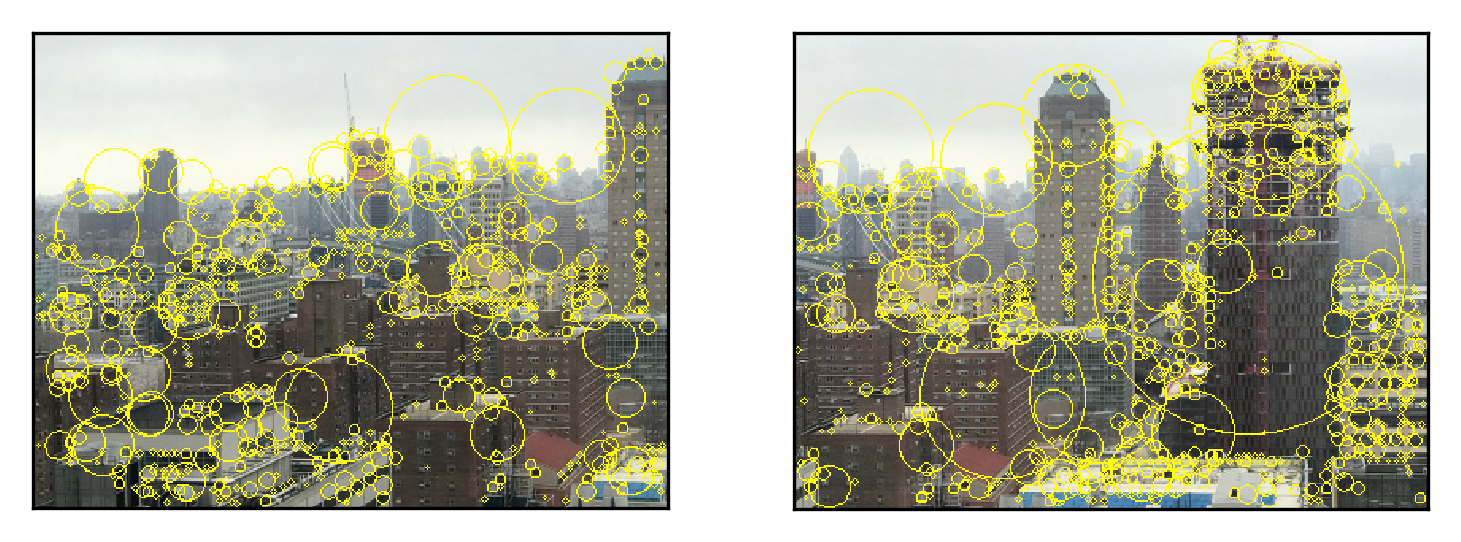

In [24]:
limg_circled = showPoint(limg, skpl)
rimg_circled = showPoint(rimg, skpr)
plt.figure(dpi=300)
plt.subplot(121)
plt.imshow(limg_circled[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])
plt.subplot(122)
plt.imshow(rimg_circled[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])

In [25]:
[Hl, Wl] = np.shape(limg[:,:,0])
[Hr, Wr] = np.shape(rimg[:,:,0])
cor_l = [int(skpl[i].pt[1] * Wl + skpl[i].pt[0]) for i in range(len(skpl))]
cor_r = [int(skpr[i].pt[1] * Wr + skpr[i].pt[0]) for i in range(len(skpr))]
sift_l = SIFT(Ixl, Iyl, cor_l)
sift_r = SIFT(Ixr, Iyr, cor_r)

In [26]:
pairs_lr = findMatch(cor_l, cor_r, sift_l, sift_r, r=0.85)
print(pairs_lr)

[[71084, 74075], [86080, 40740], [106220, 109610], [72360, 74949], [72360, 74949], [72360, 74949], [40889, 13856], [39833, 43223], [38554, 34488], [108170, 7960], [54348, 56939], [34222, 36812], [37217, 32518], [77536, 101234], [67457, 70047], [36907, 5932], [6382, 9773]]


([], <a list of 0 Text yticklabel objects>)

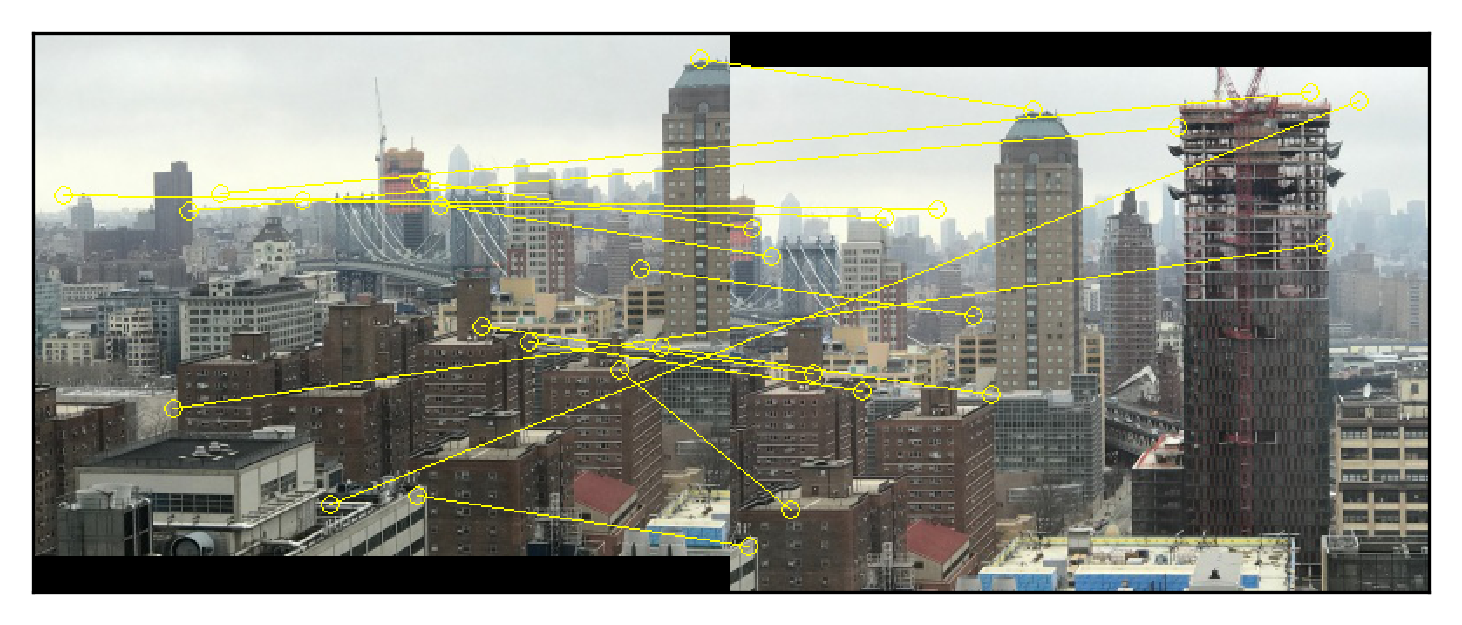

In [27]:
img_match_lr = showMatch(limg, rimg, pairs_lr, shift=20)
plt.figure(dpi=300)
plt.imshow(img_match_lr[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])

In [28]:
src_pts = np.array([(pairs_lr[i][0] % Wl, pairs_lr[i][0] // Wl) for i in range(len(pairs_lr))]).reshape(-1,1,2)
dst_pts = np.array([(pairs_lr[i][1] % Wr, pairs_lr[i][1] // Wr) for i in range(len(pairs_lr))]).reshape(-1,1,2)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5)

([], <a list of 0 Text yticklabel objects>)

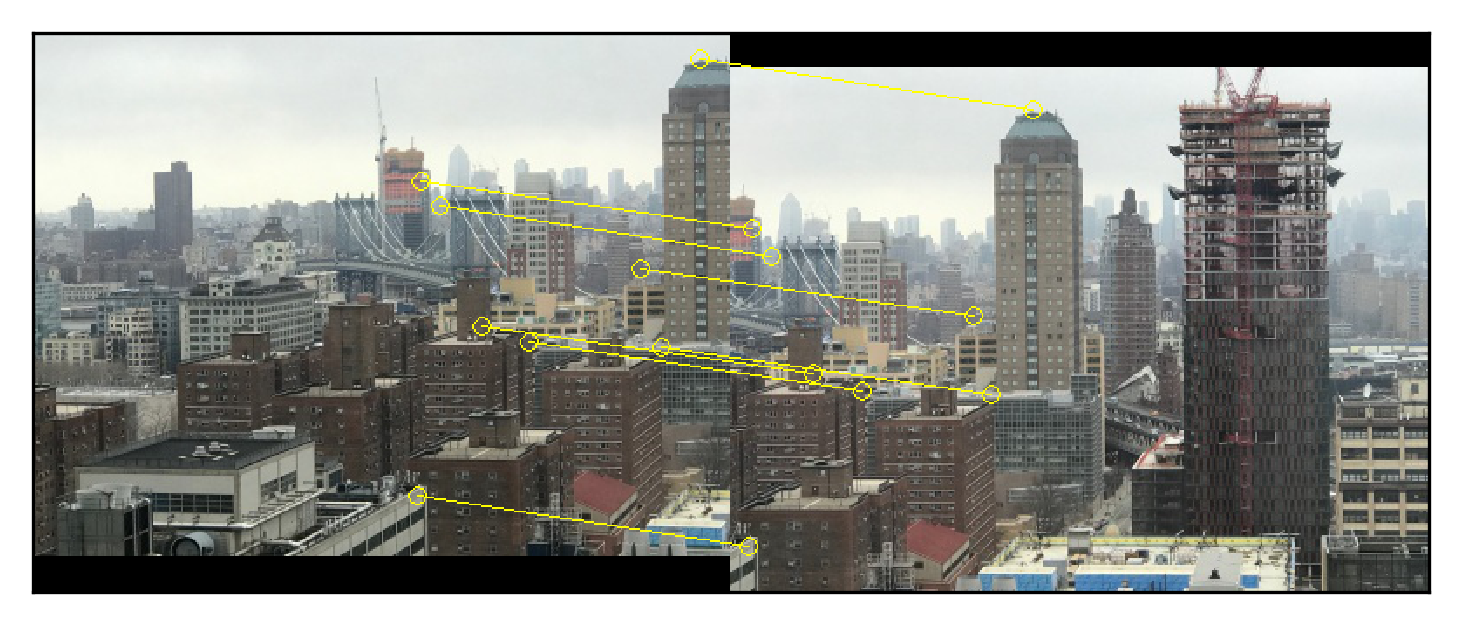

In [29]:
img_match_lr = showMatch(limg, rimg, np.array(pairs_lr)[np.array(np.where(mask[:,0] == 1)[0])].tolist(), shift=20)
plt.figure(dpi=300)
plt.imshow(img_match_lr[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])

Stitching.

In [30]:
result = cv2.warpPerspective(limg, H, (limg.shape[1] + rimg.shape[1], limg.shape[0]))
result[0:rimg.shape[0], 0:rimg.shape[1]] = rimg

([], <a list of 0 Text yticklabel objects>)

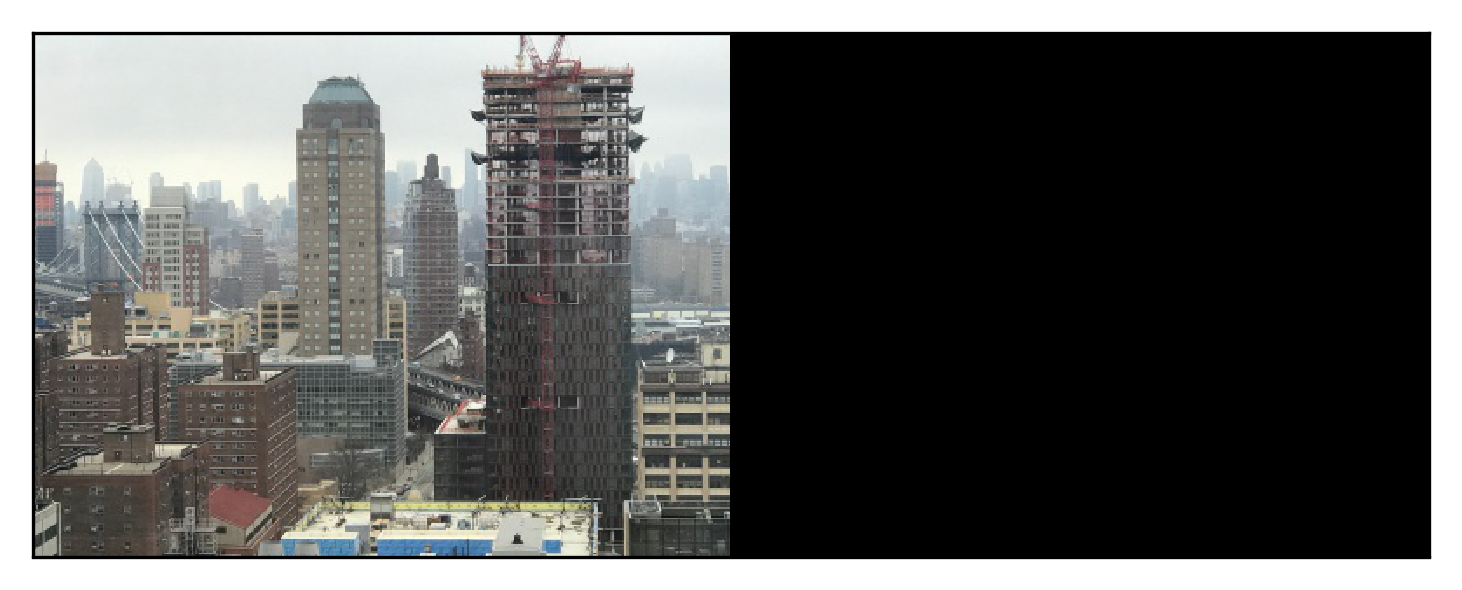

In [32]:
plt.figure(dpi=300)
plt.imshow(result[:,:,[2,1,0]])
plt.xticks([])
plt.yticks([])